In [180]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.style as style
import time

In [309]:
style.use('fivethirtyeight')
imputed = 'PATIENT_DATA_ALL_2.csv'
non_imputed = 'filename_2.txt'

In [310]:
#merged = np.genfromtxt(imputed, delimiter='\t')
merged = pd.read_csv(imputed, sep='\t', )
labels = pd.read_csv('OLD_DATA/data_clinical_sample_clean.tsv', sep='\t')

In [311]:
labels.set_index('SAMPLE_ID', inplace=True)
labels.drop(['Unnamed: 0'], axis=1, inplace=True)

In [312]:
merged.drop('PATIENT_ID', axis=1,inplace=True)
merged.drop('SAMPLE_ID', axis=1,inplace=True)
merged.drop(['Unnamed: 0'], axis=1,inplace=True)
#merged = merged.transpose()

labels = labels['ONCOTREE_CODE']
result = pd.concat([merged, labels], axis=1)

#labels = result['ONCOTREE_CODE']
#labels.columns.values[1] = 'c'

/Users/egeozin/miniconda2/envs/mm-env/lib/python3.5/site-packages/pandas/core/indexes/range.py:433: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return self._int64index.union(other)


In [313]:
random_indices = np.random.permutation(len(X))

In [314]:
X_randomized = merged.iloc[random_indices]
Y_randomized = labels[:-1].iloc[random_indices]

In [315]:
X = X_randomized.as_matrix() 
Y = Y_randomized

In [286]:
Y

SAMPLE_ID
MBC-MBCProject_BOHWtZT8-Tumor-SM-CGLQF    0
MBC-MBCProject_AqtYu0IW-Tumor-SM-DL4Y4    1
MBC-MBCProject_rmSBIguN-Tumor-SM-DL3N8    2
MBC-MBCProject_ePi1smiM-Tumor-SM-CGMFX    1
MBC-MBCProject_p1CQTdIg-Tumor-SM-CGL36    1
MBC-MBCProject_AqtYu0IW-Tumor-SM-DL3YJ    0
MBC-MBCProject_9JI1fwuX-Tumor-SM-DL4TP    1
MBC-MBCProject_K7f6fdUz-Tumor-SM-AZ5MA    0
MBC-MBCProject_ZdudUNFZ-Tumor-SM-CGLPS    1
MBC-MBCProject_kwS1CXSR-Tumor-SM-DL4SG    0
MBC-MBCProject_xBfJfri9-Tumor-SM-CGL4F    2
MBC-MBCProject_O8u9SjuW-Tumor-SM-AZ5O6    1
MBC-MBCProject_rJHBiKTl-Tumor-SM-DL3K3    1
MBC-MBCProject_kduys9h5-Tumor-SM-DL46G    1
MBC-MBCProject_epUYsdCE-Tumor-SM-DL3A1    1
MBC-MBCProject_jEhBHrS2-Tumor-SM-CGKTZ    1
MBC-MBCProject_wKuZuQS1-Tumor-SM-CGLW3    1
MBC-MBCProject_QbiZiytx-Tumor-SM-CGM9N    2
MBC-MBCProject_GouMi0U1-Tumor-SM-DL3KP    1
MBC-MBCProject_zyt5TKFB-Tumor-SM-CGM59    1
MBC-MBCProject_KphMt4F9-Tumor-SM-DL4PB    0
MBC-MBCProject_7XFmtytw-Tumor-SM-DL457    1
MBC-MBCProject_bvHXCoT

In [316]:
X_train, y_train = X[:70], Y[:70]
X_test, y_test = X[70:], Y[70:]

In [318]:
X_train.shape

(70, 106)

Dataset 2CN, train_samples=70, n_features=106, n_classes=4
Using l1 regression
[model=One versus Rest, solver=liblinear] Number of epochs: 1
[model=One versus Rest, solver=liblinear] Number of epochs: 3
Test accuracy for model ovr: 0.6250
% non-zero coefficients for model ovr, per class:
 [ 26.41509434  29.24528302  19.81132075  22.64150943]
Run time (3 epochs) for model ovr:0.00
Example run in 0.089 s


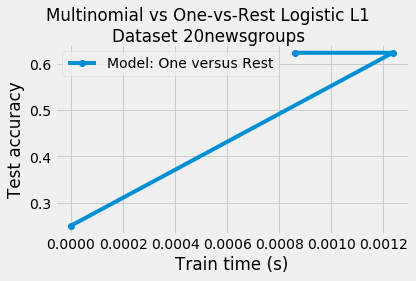

In [329]:
# Turn down for faster run time

n_samples = 10000

t0 = time.clock()

penalty = 'l1'

train_samples, n_features = X_train.shape
n_classes = np.unique(Y).shape[0]

print('Dataset 2CN, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

# Solver which handles multiclass and l1 penalty
solver = 'newton-cg'

if penalty == 'l1':
    print('Using l1 regression')
    models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]}}
    solver = 'liblinear'
    
for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty=penalty,
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1
        times.append(train_time)

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

In [330]:
times

[0, 0.0012359999999986826, 0.0008610000000004447]